In [23]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# -------------------------------
# Step 1: Load and Clean WHQ_df (with BMI Calculation)
# -------------------------------
WHQ_df = pd.read_csv('WHQ_L.csv')

# Replace the placeholder values (7777, 9999, and blanks) with NaN
WHQ_df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
WHQ_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
WHQ_df.dropna(inplace=True)

# Calculate BMI using the formula: BMI = (weight in lbs / (height in inches)^2) * 703
WHQ_df['BMI'] = (WHQ_df['WHD020'] / (WHQ_df['WHD010'] ** 2)) * 703

# Define a function to classify BMI
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Healthy Weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Class 1 Obesity'
    elif bmi < 40:
        return 'Class 2 Obesity'
    else:
        return 'Class 3 Obesity'

# Apply the classification to create a new column
WHQ_df['BMI_category'] = WHQ_df['BMI'].apply(classify_bmi)

WHQ_df.drop(['WHD010', 'WHD020', 'WHD050' ,'WHQ070', 'BMI' ], axis=1, inplace=True)

print("First few rows of cleaned WHQ_df:")
print(WHQ_df.head())

First few rows of cleaned WHQ_df:
       SEQN     BMI_category
0  130378.0       Overweight
1  130379.0  Class 1 Obesity
2  130380.0       Overweight
3  130384.0  Class 1 Obesity
4  130385.0  Class 1 Obesity


In [25]:
# -------------------------------
# Step 2: Load the Other DataFrames
# -------------------------------
ALQ_df = pd.read_csv('ALQ_L.csv')
BAX_df = pd.read_csv('BAX_L.csv')
#BMX_df    = pd.read_csv('BMX_L.csv')
BPQ_df = pd.read_csv('BPQ_L.csv')
BPXO_df = pd.read_csv('BPXO_L.csv')
DBQ_df = pd.read_csv('DBQ_L.csv')
DEMO_df = pd.read_csv('DEMO_L.csv')
DR1IFF_df = pd.read_csv('DR1IFF_L.csv')
MCQ_df = pd.read_csv('MCQ_L.csv')
PAQ_df = pd.read_csv('PAQ_L.csv')
# Note: WHQ_df is already loaded and processed above.

In [26]:
# -------------------------------
# Step 3: Merge All DataFrames on 'SEQN'
# -------------------------------
dfs = [ALQ_df, BAX_df, BPQ_df, BPXO_df, DBQ_df, DEMO_df, DR1IFF_df, MCQ_df, PAQ_df, WHQ_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

print("Columns in merged_df:")
print(merged_df.columns)

Columns in merged_df:
Index(['SEQN', 'ALQ111', 'ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280',
       'ALQ151', 'ALQ170', 'BAXMSTAT',
       ...
       'MCQ230D', 'OSQ230', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q',
       'PAD810U', 'PAD820', 'PAD680', 'BMI_category'],
      dtype='object', length=246)


In [27]:
# -------------------------------
# Step 4: Clean Merged Data
# -------------------------------
# Drop rows missing the target 'BMI_category'
merged_df.dropna(subset=['BMI_category'], inplace=True)

# Fill missing values with 0 for all remaining columns
merged_df.fillna(0, inplace=True)

In [28]:
# -------------------------------
# Step 5: Prepare Features and Target
# -------------------------------
y = merged_df['BMI_category']
X = merged_df.drop(['BMI_category', 'SEQN'], axis=1)

# One-hot encode categorical variables in X
X = pd.get_dummies(X)

In [29]:
# -------------------------------
# Step 6: Stratified Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
# -------------------------------
# Step 7: Scaling Features
# -------------------------------
scaler = StandardScaler()

# Scale the training data and transform test data, preserving column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [31]:
# -------------------------------
# Step 8: Apply SMOTE to Balance the Training Data
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Training set distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\nTest set distribution (original composition):")
print(y_test.value_counts())

Training set distribution after SMOTE:
BMI_category
Overweight         21512
Class 1 Obesity    21512
Class 2 Obesity    21512
Healthy Weight     21512
Class 3 Obesity    21512
Underweight        21512
Name: count, dtype: int64

Test set distribution (original composition):
BMI_category
Overweight         5379
Healthy Weight     5042
Class 1 Obesity    2941
Class 2 Obesity    1297
Class 3 Obesity     996
Underweight         280
Name: count, dtype: int64


In [32]:
# -------------------------------
# Step 9: Train XGBoost Model
# -------------------------------

# Initialize encoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_res_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)

# Check encoding mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

xgb_model = XGBClassifier(
    n_estimators=1000,  # Increase trees
    learning_rate=0.05,  # Slow learning rate to prevent overfitting
    max_depth=6,  # Increase depth for better feature learning
    subsample=0.9,  # Use 90% of data per tree
    colsample_bytree=0.9,  # Use 90% of features per tree
    reg_alpha=0.1,  # Reduce regularization slightly
    reg_lambda=1,  # Reduce L2 regularization
    random_state=42
)

Label Mapping: {'Class 1 Obesity': 0, 'Class 2 Obesity': 1, 'Class 3 Obesity': 2, 'Healthy Weight': 3, 'Overweight': 4, 'Underweight': 5}


In [33]:
# Train on resampled data
xgb_model.fit(X_train_res, y_train_res_encoded)

# Predict on test data
y_pred_xgb_encoded = xgb_model.predict(X_test_scaled)

# Convert predictions back to original class labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Evaluate performance
from sklearn.metrics import classification_report
print("XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       0.97      0.97      0.97      2941
Class 2 Obesity       0.99      0.97      0.98      1297
Class 3 Obesity       0.98      0.96      0.97       996
 Healthy Weight       0.98      0.98      0.98      5042
     Overweight       0.97      0.98      0.97      5379
    Underweight       0.98      0.94      0.96       280

       accuracy                           0.98     15935
      macro avg       0.98      0.97      0.97     15935
   weighted avg       0.98      0.98      0.98     15935



In [34]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode labels to numeric values
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_res)  # y_train_res from SMOTE-resampled training data
y_test_encoded = le.transform(y_test)

# Initialize and train XGBoost for multiclass classification
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)
xgb_model.fit(X_train_res, y_train_encoded)

# Make predictions on the training and test sets
y_pred_train = xgb_model.predict(X_train_res)
y_pred_test = xgb_model.predict(X_test_scaled)

# Convert numeric predictions back to original string labels
y_pred_train_labels = le.inverse_transform(y_pred_train)
y_pred_test_labels = le.inverse_transform(y_pred_test)
y_train_labels = le.inverse_transform(y_train_encoded)
y_test_labels = le.inverse_transform(y_test_encoded)

print("Training Performance:")
print(classification_report(y_train_labels, y_pred_train_labels))

print("Test Performance:")
print(classification_report(y_test_labels, y_pred_test_labels))


Training Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       0.99      0.98      0.99     21512
Class 2 Obesity       0.99      1.00      0.99     21512
Class 3 Obesity       1.00      1.00      1.00     21512
 Healthy Weight       0.98      0.99      0.99     21512
     Overweight       0.98      0.98      0.98     21512
    Underweight       1.00      1.00      1.00     21512

       accuracy                           0.99    129072
      macro avg       0.99      0.99      0.99    129072
   weighted avg       0.99      0.99      0.99    129072

Test Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       0.97      0.97      0.97      2941
Class 2 Obesity       0.97      0.96      0.97      1297
Class 3 Obesity       0.98      0.97      0.97       996
 Healthy Weight       0.97      0.98      0.97      5042
     Overweight       0.97      0.96      0.97      5379
    Underweight       0.98      0.94      0.

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

# -------------------------------
# Preliminary Model Training for Permutation Importance
# -------------------------------
# Here we incorporate the additional hyperparameters.
prelim_xgb = XGBClassifier(
    n_estimators=1000,         
    learning_rate=0.05,        
    max_depth=5,              # Reduced depth to make trees shallower
    subsample=0.9,            
    colsample_bytree=0.9,     
    gamma=1,                  # Require a minimum loss reduction for splitting
    min_child_weight=5,       # Increase minimum child weight to avoid splitting on very few samples
    reg_alpha=0.5,            # Increase L1 regularization
    reg_lambda=2,             # Increase L2 regularization
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42
)

# Train the preliminary model on all features (using SMOTE-resampled training data)
prelim_xgb.fit(X_train_res, y_train_encoded)

# Compute permutation importance on the test set
perm_importance = permutation_importance(
    prelim_xgb, X_test_scaled, y_test_encoded, 
    n_repeats=10, random_state=42, scoring='f1_macro'
)

# Get sorted indices (largest importance first) and select top 10 features
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_features = X_train_scaled.columns[sorted_idx][:14]
print("Top Features Selected:", top_features.tolist())


Top Features Selected: ['BPAOCSZ', 'BPXOPLS3', 'RIDAGEYR', 'WTMEC2YR', 'WTINT2YR', 'BPXODI2', 'BPXODI1', 'PAD680', 'RIAGENDR', 'BPXODI3', 'DR1DBIH', 'BPXOSY2', 'WTDR2D', 'MCQ195']


In [36]:
# -------------------------------
# Final Model Training Using Selected Features
# -------------------------------

# Subset the training and test data to include only the top features
X_train_top = X_train_res[top_features]
X_test_top = X_test_scaled[top_features]

# Initialize and train the final XGBoost model with the specified hyperparameters
final_xgb = XGBClassifier(
    n_estimators=1000,         
    learning_rate=0.05,        
    max_depth=5,              # Reduced depth to make trees shallower
    subsample=0.9,            
    colsample_bytree=0.9,     
    gamma=1,                  # Require a minimum loss reduction for splitting
    min_child_weight=5,       # Increase minimum child weight to avoid splitting on very few samples
    reg_alpha=0.5,            # Increase L1 regularization
    reg_lambda=2,             # Increase L2 regularization
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42
)

final_xgb.fit(X_train_top, y_train_encoded)

# Make predictions on both the training and test sets
y_pred_train_final = final_xgb.predict(X_train_top)
y_pred_test_final = final_xgb.predict(X_test_top)

# Convert numeric predictions back to original string labels
y_pred_train_final_labels = le.inverse_transform(y_pred_train_final)
y_pred_test_final_labels = le.inverse_transform(y_pred_test_final)

# Evaluate and print the classification reports
print("Final XGBoost Model Performance on Training Set:")
print(classification_report(y_train_labels, y_pred_train_final_labels))

print("Final XGBoost Model Performance on Test Set:")
print(classification_report(y_test_labels, y_pred_test_final_labels))

Final XGBoost Model Performance on Training Set:
                 precision    recall  f1-score   support

Class 1 Obesity       0.95      0.96      0.96     21512
Class 2 Obesity       0.97      0.97      0.97     21512
Class 3 Obesity       0.98      0.98      0.98     21512
 Healthy Weight       0.95      0.97      0.96     21512
     Overweight       0.97      0.94      0.95     21512
    Underweight       0.99      0.99      0.99     21512

       accuracy                           0.97    129072
      macro avg       0.97      0.97      0.97    129072
   weighted avg       0.97      0.97      0.97    129072

Final XGBoost Model Performance on Test Set:
                 precision    recall  f1-score   support

Class 1 Obesity       0.93      0.96      0.94      2941
Class 2 Obesity       0.93      0.96      0.94      1297
Class 3 Obesity       0.95      0.97      0.96       996
 Healthy Weight       0.94      0.97      0.95      5042
     Overweight       0.96      0.92      0.94 

C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-

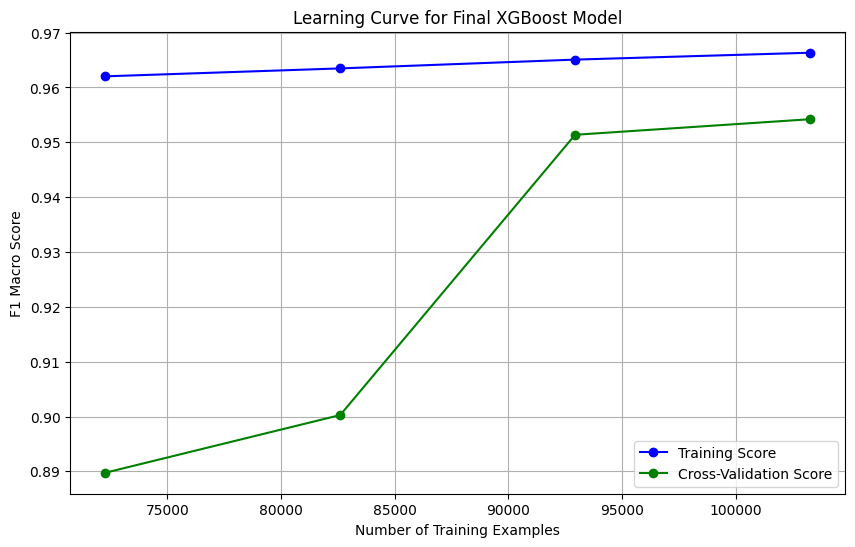

In [37]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_xgb is your final XGBoost model and X_train_top are the features selected
# using permutation importance and y_train_encoded are your encoded labels.

# Compute learning curves using 5-fold cross-validation
train_sizes, train_scores, cv_scores = learning_curve(
    final_xgb, 
    X_train_top, 
    y_train_encoded, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean scores across folds
train_scores_mean = np.mean(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, cv_scores_mean, 'o-', color='green', label='Cross-Validation Score')
plt.title('Learning Curve for Final XGBoost Model')
plt.xlabel('Number of Training Examples')
plt.ylabel('F1 Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [38]:
# -------------------------------
# Final Model Training Using Manually Selected Features
# -------------------------------

# Manually selected features (replace these placeholders with your chosen features)
manual_features = [
    'RIDAGEYR',
    'INDFMPIR',
    'WTMEC2YR',
    'BPXOPLS3',
    'BPXOPLS2',
    'BPXOPLS1',
    'DR1DBIH',
    'WTDRD1',
    'BPXOSY2',
    'BPXOSY3',
    'BPXOSY1',
    'DR1ILINE',
    'WTDR2D',
    'PAD680'
]

# Subset the training and test data to include only the manually selected features
X_train_top = X_train_res[manual_features]
X_test_top = X_test_scaled[manual_features]

# Initialize and train the final XGBoost model with the specified hyperparameters
final_xgb = XGBClassifier(
    n_estimators=1000,         
    learning_rate=0.05,        
    max_depth=5,              # Reduced depth to make trees shallower
    subsample=0.9,            
    colsample_bytree=0.9,     
    gamma=1,                  # Require a minimum loss reduction for splitting
    min_child_weight=5,       # Increase minimum child weight to avoid splitting on very few samples
    reg_alpha=0.5,            # Increase L1 regularization
    reg_lambda=2,             # Increase L2 regularization
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42
)

final_xgb.fit(X_train_top, y_train_encoded)

# Make predictions on both the training and test sets
y_pred_train_final = final_xgb.predict(X_train_top)
y_pred_test_final = final_xgb.predict(X_test_top)

# Convert numeric predictions back to original string labels
y_pred_train_final_labels = le.inverse_transform(y_pred_train_final)
y_pred_test_final_labels = le.inverse_transform(y_pred_test_final)

# Evaluate and print the classification reports
print("Final XGBoost Model Performance on Training Set:")
print(classification_report(y_train_labels, y_pred_train_final_labels))

print("Final XGBoost Model Performance on Test Set:")
print(classification_report(y_test_labels, y_pred_test_final_labels))


Final XGBoost Model Performance on Training Set:
                 precision    recall  f1-score   support

Class 1 Obesity       0.95      0.94      0.94     21512
Class 2 Obesity       0.96      0.95      0.96     21512
Class 3 Obesity       0.95      0.97      0.96     21512
 Healthy Weight       0.95      0.94      0.95     21512
     Overweight       0.95      0.95      0.95     21512
    Underweight       0.98      0.99      0.98     21512

       accuracy                           0.96    129072
      macro avg       0.96      0.96      0.96    129072
   weighted avg       0.96      0.96      0.96    129072

Final XGBoost Model Performance on Test Set:
                 precision    recall  f1-score   support

Class 1 Obesity       0.95      0.93      0.94      2941
Class 2 Obesity       0.94      0.96      0.95      1297
Class 3 Obesity       0.93      0.95      0.94       996
 Healthy Weight       0.94      0.94      0.94      5042
     Overweight       0.95      0.94      0.94 